In [78]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize, rotate
import math

In [3]:
images_path = "./pictures/"
masks_path = "./groupR_masks/"
path = "131_197_260"

def prepare_im(im_id):
    prefix = 'PAT'
    extension = ".png"
    im = plt.imread(f"{images_path}{prefix}_{im_id}{extension}")
    im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)
    
    gt = im = plt.imread(f"{masks_path}{prefix}_{im_id}_mask{extension}")
    gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=False) #Setting it to True creates values that are not 0 or 1
    
    return im, gt

im, gt = prepare_im(path)

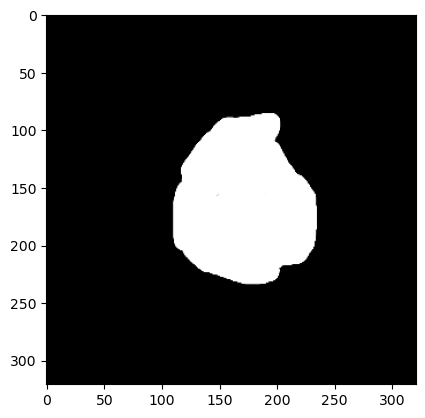

In [4]:
plt.imshow(gt, cmap="gray")

In [76]:
180%17

10

In [89]:
180/59
list(range(0,180,59))

[0, 59, 118, 177]

In [153]:
def get_cropped(img, padding=0):
    """Crops the image to bounding boxes with given padding"""
    cords = np.where(img!=0)
    x1, y1 = min(cords[0]), max(cords[1])
    x2, y2 = max(cords[0]), min(cords[1])
    cr = img[x1-padding:x2+padding, y2-padding:y1+padding]
    return cr

def flip(img):
    return img[:,::-1]

In [205]:
def asymmetry_score_fully_rotated(img, n_steps: int = 10):
    """Rotates images step times around axis, and computes overlapping percentage
    Best score: 1, worst score: 0. Insert cropped image"""
    if (n_steps <  1 or n_steps > 180):
        raise Exception('Amount of steps of range [1, 180]')

    img = get_cropped(img)
    sum_of_overlapping_areas = 0
    total_area = np.sum(img)*n_steps
    step_size = math.ceil(180 / n_steps)
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        overlap = left_half * flipped_right_half
        
        overlapping_area = np.sum(overlap)
        sum_of_overlapping_areas += overlapping_area
        
    score = (2*sum_of_overlapping_areas / total_area) # need to account for both halves
    return score
asymmetry_score_fully_rotated(gt, 180)

0.870248042469451

In [204]:
def asymmetry_score_one_max_rotated(img):
    """Returns maximum overlap for any possible axis.
    Best score: 1, worst score: 0."""

    img = get_cropped(img)
    max_overlapping_area = 0
    total_area = np.sum(img)
    step_size = 1
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        overlap = left_half * flipped_right_half
        
        overlapping_area = np.sum(overlap)
        if (overlapping_area > max_overlapping_area):
            max_overlapping_area = overlapping_area
        
    score = (2*max_overlapping_area / total_area) # need to account for both halves
    return score
asymmetry_score_one_max_rotated(gt)

0.9400886730363905

In [210]:
def asymmetry_score_major_minor_overlap(img):
    """Finds the axis yielding highest overlap and treats it as major axis. Return summed percentage overlap of minor and major
    axes.
    Best score: 1, worst score: 0"""

    img = get_cropped(img)
    major_max_overlapping_area = 0
    minor_overlapping_area = 0
    total_area = np.sum(img)
    step_size = 1
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        major_overlap = left_half * flipped_right_half

        major_overlapping_area = np.sum(major_overlap)
        if (major_overlapping_area > major_max_overlapping_area):
            major_max_overlapping_area = major_overlapping_area
            
            middle_row = rotated_mask.shape[0] // 2
            
            top_half = rotated_mask[:middle_row, :]
            flipped_bottom_half = flip(rotated_mask[-middle_row:, :])
            
            minor_overlap = top_half * flipped_bottom_half
            minor_overlapping_area = np.sum(minor_overlap)
        
    score = ((major_max_overlapping_area+minor_overlapping_area) / total_area) # need to account for both halves
    return score
asymmetry_score_major_minor_overlap(gt)

0.8286755

In [223]:
min((1,8), (10, 9))

(1, 8)

In [211]:
def asymmetry_classic(img):
    """ Finds major axis using minimum bounding box methods and return combined overlap percentage"""
    img = get_cropped(img, padding=0)
    # Lexographic order

    
    step_size = 1
    min_bounding_box = None
    min_bounding_box_size = np.sum(img)
    
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        bounding_box = get_cropped(rotated_mask, padding=0)
        bounding_box_size = np.sum(bounding_box)
        if(min_bounding_box_size > bounding_box_size):
            min_bounding_box = bounding_box
    # Follow alongside major axis

    if(
    
        
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        major_overlap = left_half * flipped_right_half

        major_overlapping_area = np.sum(major_overlap)
        if (major_overlapping_area > major_max_overlapping_area):
            major_max_overlapping_area = major_overlapping_area
            
            middle_row = rotated_mask.shape[0] // 2
            
            top_half = rotated_mask[:middle_row, :]
            flipped_bottom_half = flip(rotated_mask[-middle_row:, :])
            
            minor_overlap = top_half * flipped_bottom_half
            minor_overlapping_area = np.sum(minor_overlap)
        
    score = ((major_max_overlapping_area+minor_overlapping_area) / total_area) # need to account for both halves
    return score
asymmetry_class(gt)

0.8286755

In [ ]:
def asymmetry_4_fold(img):
    

In [ ]:
def asymmetry_class_major_minor(img):
    

In [ ]:
def asymmetry_score_max_rotated(img):
    """Rotates images 180 times around axis, and computes percentage for the maximum overlap axis
    Best score: 1, worst score: 0. Insert cropped image"""
    n_steps = 180
    img = get_cropped(img)
    min_nonoverlapping_area = np.sum(img) # This is possible max
    total_area = np.sum(img)
    step_size = 1
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        overlapping_area = left_half * flipped_right_half
        # (left_half - rotated_area) + (flipped_right_half - rotated_area)
        nonoverlapping_area = np.sum(left_half)+np.sum(flipped_right_half)-2*np.sum(overlapping_area)
        if (min_nonoverlapping_area > nonoverlapping_area):
            min_nonoverlapping_area = nonoverlapping_area
        
    score = 1 - (sum_of_nonoverlapping_areas / total_area)
    return score

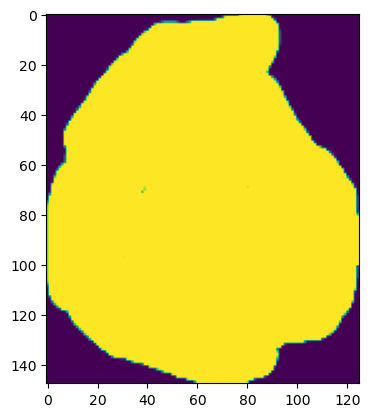

In [19]:
cr = get_cropped(gt)

plt.imshow(cr)

0.9338123206136268

In [ ]:
asymmetry_score(cr,1)

# WOrkshop below - no important. Above is ready code.

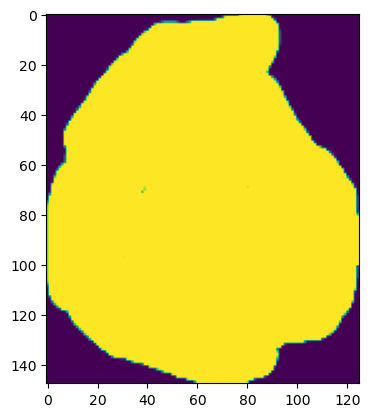

In [33]:
img = cr
angle = 0
rotated_mask = rotate(img, angle, True)
# There is no need to crop the image to boundary boxes, 
# because the center remains in the middle
# but we are doing it, because I think it should speed up the process.
middle_column = rotated_mask.shape[1] // 2
left_half = rotated_mask[:, :middle_column]
flipped_right_half = flip(rotated_mask[:, -middle_column:])
overlap = left_half * flipped_right_half
# (left_half - rotated_area) + (flipped_right_half - rotated_area)
nonoverlapping_area = np.sum(left_half)+np.sum(flipped_right_half)-2*np.sum(overlap)
#sum_of_nonoverlapping_areas += nonoverlapping_area

plt.imshow(rotated_mask)

In [ ]:
plt.imshow(flipped_right_half - overlap)

In [ ]:
plt.imshow(flipped_right_half-overlap)